In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import bumps

# Sage and Lorenzo, edit the path to sasview for sas below
import sas


In [2]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual volume percentages
data = np.loadtxt('../../data/uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual = {}
actual_stdev = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual[key] = act_vol
    actual_stdev[key] = stdev_vol
    
slds = {'RRe-P3HT':0.676,
       'RRa-P3HT':0.676,
       'P3DDT':0.316,
       'PQT-12':0.676,
       #'Polystyrene-D8':6.407,
       'Polystyrene-D8':6.464, # density of 1.13 g/mL
       'Polystyrene-H8':1.426}


In [3]:
data_dir = '../../data/sans/Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)

Splitting up the fits

In [4]:
true_keys = []

true_reads = pd.read_csv('../../data/sans/Fit_Truths.csv')
true_reads = true_reads.to_numpy()
mask = true_reads[:,1].astype(bool)

sphere_keys = true_reads[mask,0]

split_num = int(len(sphere_keys)/3)

# Sage, uncomment the next line for the samples you will run
#run_keys = list(sphere_keys[:split_num])

# Lorenzo, uncomment the next line for the samples you will run
#run_keys = list(sphere_keys[split_num:2*split_num])

# Caitlyn, uncomment the next line for the samples you will run
# run_keys = list(sphere_keys[split_num*2:])

Loading polystyrene fit information.

In [5]:
background_files = [file for file in os.listdir('../../data/sans/PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)

In [6]:
power_law_fit_info = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
ps_scales = {}

for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_exp_95 = value['p95']
    else:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])

In [7]:
guinier_porod_fit = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
adjusted_scales = {}
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        
for key in rgs.keys():
    q1 = (1/rgs[key][0]) * np.sqrt((ps_porod_exp - ps_s)*(3-ps_s)/2)
    new_scale = ps_scales[key][0] * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    new_95p = np.array(ps_scales[key][1]) * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    adjusted_scales[key] = (new_scale, list(new_95p))

In [8]:
ps_s

2.527970343604298

In [9]:
ps_porod_exp

3.495374117152284

We will set limits for the polystyrene portion of the fit based on average values from the guinier_porod polystyrene fits. The scale will also be adjusted based on 1-x where x is the volume fraction of conjugated polymer in each specific sample as determined by UV-Vis. We are assuming that volume fraction is equivalent to weight fraction in this case; estimates show that error is minimal.

In [10]:
avg_rg = np.average([x[0] for x in rgs.values()])
max_rg = np.max([x[1][1] for x in rgs.values()])
min_rg = np.min([x[1][0] for x in rgs.values()])

In [11]:
avg_scale = np.average([x[0] for y, x in ps_scales.items() if y in rgs.keys()])
max_scale = np.average([x[1][1] for y, x in ps_scales.items() if y in rgs.keys()])
min_scale = np.average([x[1][0] for y, x in ps_scales.items() if y in rgs.keys()])


In [12]:
avg_rg

180.08039395244816

In [13]:
avg_scale

0.00021282869261837612

Loading the Porod analysis results, we will only utilize the previously determined background values to minimize the fitting here.

In [14]:
porod_files = [file for file in os.listdir('../../data/sans/Porod_analysis/porod_results') if 'json' in file]

for file in porod_files:
    data_read = pd.read_json('../../data/sans/Porod_analysis/porod_results/' + file)
    key = int(file.split('_')[0][3:])
    for column, value in data_read.items():
        if 'background' in column:
            backgrounds[key] = (value['best'], value['p95']) 

In [15]:
kernel = load_model("guinier_porod+sphere")
model = Model(kernel)
model.parameters()

{'scale': Parameter(scale),
 'background': Parameter(background),
 'A_scale': Parameter(A_scale),
 'A_rg': Parameter(A_rg),
 'A_s': Parameter(A_s),
 'A_porod_exp': Parameter(A_porod_exp),
 'B_scale': Parameter(B_scale),
 'B_sld': Parameter(B_sld),
 'B_sld_solvent': Parameter(B_sld_solvent),
 'B_radius': Parameter(B_radius),
 'B_radius_pd': Parameter(B_radius_pd),
 'B_radius_pd_n': Parameter(B_radius_pd_n),
 'B_radius_pd_nsigma': Parameter(B_radius_pd_nsigma),
 'up_frac_i': Parameter(up_frac_i),
 'up_frac_f': Parameter(up_frac_f),
 'up_angle': Parameter(up_angle),
 'B_sld_M0': Parameter(B_sld_M0),
 'B_sld_mtheta': Parameter(B_sld_mtheta),
 'B_sld_mphi': Parameter(B_sld_mphi),
 'B_sld_solvent_M0': Parameter(B_sld_solvent_M0),
 'B_sld_solvent_mtheta': Parameter(B_sld_solvent_mtheta),
 'B_sld_solvent_mphi': Parameter(B_sld_solvent_mphi)}

# steps: 1000, # draws: 20000
step 1 cost 145.9819(74)
                        25 sphere radius |.........    800.138 in (0,150000)
                         25 sphere scale |......... 0.00136102 in (0,0.5)
step 11 cost 13.4211(74)
step 19 cost 13.4043(74)
step 32 cost 13.2772(74)
step 46 cost 11.7677(74)
step 59 cost 11.7603(74)
step 73 cost 11.7558(74)
step 87 cost 11.7558(74)
step 101 cost 11.7548(74)
step 114 cost 11.7548(74)
step 128 cost 11.7544(74)
step 142 cost 11.7544(74)
step 153 cost 11.7544(74)
step 166 cost 11.7544(74)
step 179 cost 11.7544(74)
step 193 cost 11.7544(74)
step 207 cost 11.7544(74)
step 220 cost 11.7544(74)
step 234 cost 11.7544(74)
step 247 cost 11.7544(74)
step 260 cost 11.7544(74)
step 273 cost 11.7544(74)
step 286 cost 11.7544(74)
step 300 cost 11.7544(74)
step 314 cost 11.7544(74)
step 327 cost 11.7544(74)
step 340 cost 11.7544(74)
step 354 cost 11.7544(74)
step 367 cost 11.7544(74)
                        25 sphere radius |.........    1434.91 in (0,1500

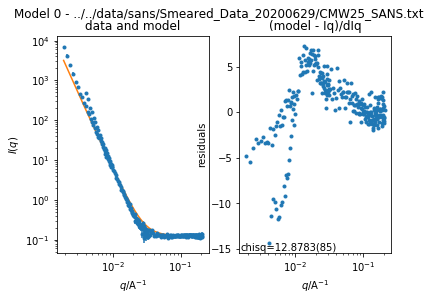

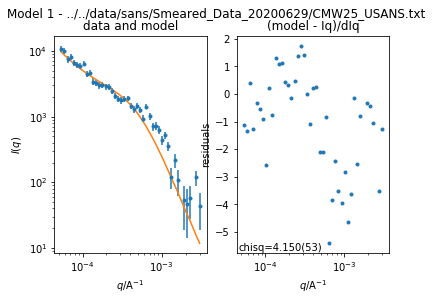

In [33]:
results = {}

kernel = load_model("guinier_porod+sphere")

run_keys = [25]

#run_keys = [key for key in run_keys if key in actual.keys() and key in usans_data.keys()]
for key in run_keys:
    
    # loading the data
    sans = sans_data[key]
    sans.dx = sans.dx-sans.dx # removing smearing from sans segment
    usans = usans_data[key]
    
    vol = actual[key]/100 # cp volume fraction from uv-vis
    vol_stdev = actual_stdev[key]/100
    
    # initial parameter values
    
    scale = Parameter(1, name=str(key) + 'scale')
    background = Parameter(backgrounds[key][0], name=str(key) + 'background')
    
    A_scale = Parameter(avg_scale*(1-vol), name=str(key) + ' PS scale')
    A_rg = Parameter(avg_rg, name=str(key) + ' PS rg')
    A_s = Parameter(ps_s, name=str(key) + ' PS s')
    A_porod_exp = Parameter(ps_porod_exp, name=str(key) + ' PS porod_exp')
    
    B_scale_normal = bumps.bounds.BoundedNormal(mu=vol, sigma=vol_stdev, limits=(0, inf))
    B_scale = Parameter(vol*2, name=str(key) + ' sphere scale').range(0,0.5)#, bounds=B_scale_normal)
    
    B_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    B_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')
    B_radius = Parameter(800, limits=[0,inf], name=str(key) + ' sphere radius')
    B_radius_pd = Parameter(0.5, name = str(key) + ' sphere radius pd')
    B_radius_pd_n = Parameter(200, name = str(key) + ' sphere radius pd n')
    B_radius_pd_nsigma = Parameter(8, name = str(key) + ' sphere radius pd nsigma') 
    
    # setting up the combined model for fitting
    sans_model = Model(
        model=kernel,
        scale=scale,
        background=background,
        A_scale=A_scale,
        A_rg=A_rg,
        A_s=A_s,
        A_porod_exp=A_porod_exp,
        B_scale=B_scale,
        B_sld=B_sld,
        B_sld_solvent=B_sld_solvent,
        B_radius=B_radius,
        B_radius_pd_type='lognormal',
        B_radius_pd=B_radius_pd,
        B_radius_pd_n=B_radius_pd_n,
        B_radius_pd_nsigma=B_radius_pd_nsigma,
    )

    # setting parameter ranges as needed
    
#     sans_model.A_scale.range(min_scale*(1-vol), max_scale*(1-vol))
#     sans_model.A_rg.range(min_rg, max_rg)
#     sans_model.A_s.range(min(ps_s, ps_s_95[0]), max(ps_s, ps_s_95[1]))
#     sans_model.A_porod_exp.range(min(ps_porod_exp, ps_porod_exp_95[0]), max(ps_porod_exp, ps_porod_exp_95[1]))
    
    sans_model.B_radius.range(0,150000)
    #sans_model.B_scale.range(vol-vol_stdev, vol+vol_stdev)

    sans_experiment=Experiment(data=sans, model=sans_model)
    usans_experiment=Experiment(data=usans, model=sans_model)

    usans_smearing = sasmodels.resolution.Slit1D(usans.x, 0.117)
    usans_experiment.resolution = usans_smearing

    experiment = [sans_experiment, usans_experiment]

    problem=FitProblem(experiment, weights=[0.1,0.9])
    result=fit(problem, method='dream', samples=1e6, verbose=True,steps=1000)
    #result.state.show(figfile='../data/sans/Sample_Fitting/fitting_results/ps_sphere/CMW' + str(key) + '_ps_sphere')
    #plt.close()
    problem.plot()

    results[key] = problem


              Parameter       mean  median    best [   68% interval] [   95% interval]
 1      7 sphere radius  401.3(46)  401.26  400.06 [  397.1   405.6] [  393.0   409.8]
 2       7 sphere scale 0.003940(50) 0.003939 0.003927 [0.00389 0.00399] [0.00385 0.00403]


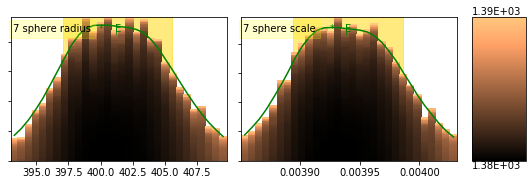

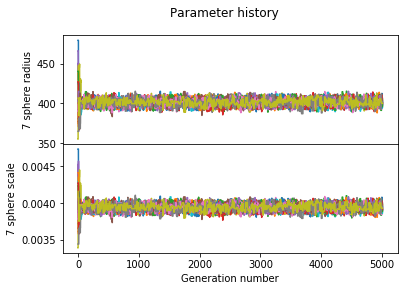

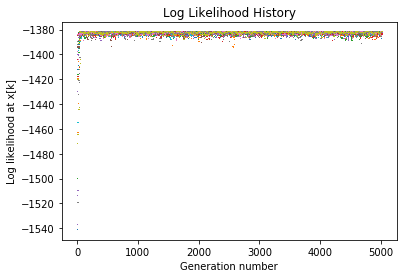

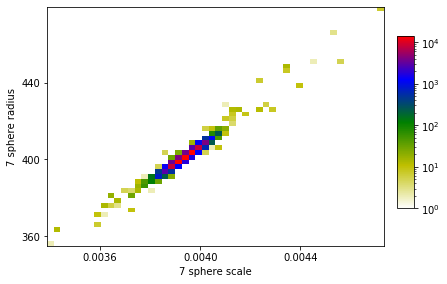

In [25]:
result.state.show(figfile='../../data/sans/Sample_Fitting/fitting_results/ps_sphere/CMW' + str(key) + '_ps_sphere')

In [ ]:
for key, problem in results.items():
    print(key)
    problem.plot()
    plt.show()
    plt.close()